## Project description and business understanding

### Project objective
The objective of the project is to get the best possible used car price prediction in accordance to a set of available dimensions and metrics with use of ML methods that I have learned from the Data Science extramural Bootcamp. 

The data for the project is a real world used car ads records originated from Kaggle (https://www.kaggle.com/mirosval/personal-cars-classifieds). The data was scraped by Miroslav Zoricak from several websites in Czech Republic and Germany over a period of more than a year within late 2015 and early 2017.

The original dataframe includes the following columns:
- <b>maker</b>- normalized all lowercase
- <b>model</b> - normalized all lowercase
- <b>mileage</b> - in KM
- <b>manufacture_year</b>
- <b>engine_displacement</b> - in ccm
- <b>engine_power</b> - in kW (converted during data prep to HP)
- <b>body_type</b> - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
- <b>color_slug</b> - also almost never present
- <b>stk_year</b> - year of the last emission control
- <b>transmission</b> - automatic or manual
- <b>door_count</b>
- <b>seat_count</b>
- <b>uel_type</b> - gasoline, diesel, cng, lpg, electric
- <b>date_created</b> - when the ad was scraped
- <b>datelastseen</b> - when the ad was last seen. Our policy was to remove all ads older than 60 days
- <b>price_eur</b> - list price converted to EUR

I decided to limit the period of scraping, and set it between October 2016 and March 2017.

The autor of the data claims that data scraped can not provide accurate predictions due to data quality issues, ie. missing values, variance, and presence of outliers. Having this noted, thorough data cleansing is one of the major project challanges. The possible outcome can bring up significant data reduction, but should increase accuracy of predictions.

It is also important to remark that data provided does not contain such important information as condition of a car, malnufunctions, or possible damages. They are all crucial to better set up and predict the price for the model.  

Despite this leakage I will attempt to reach best possible R2 score in general and check out how the price predictions perform across most popular CEE brands and models. 

## Getting and limiting the raw file

In [475]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

random_seed=42

In [441]:
df = pd.read_csv('./cars.csv', sep=',', low_memory=False)
df.head(5)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


Converting engine_power from kW to HP units.

In [442]:
df['engine_power'] = 1.3410220888*df['engine_power']

Checking out when cars were scraped:

In [443]:
import datetime as dt

df['year'] = pd.to_datetime(df['date_created']).dt.year
df['month'] = pd.to_datetime(df['date_created']).dt.month.map("{:02}".format)

df['created_year_month']= df[['year', 'month']].astype(str).agg('_'.join, axis=1)

df.sort_values(by='created_year_month', inplace=True)

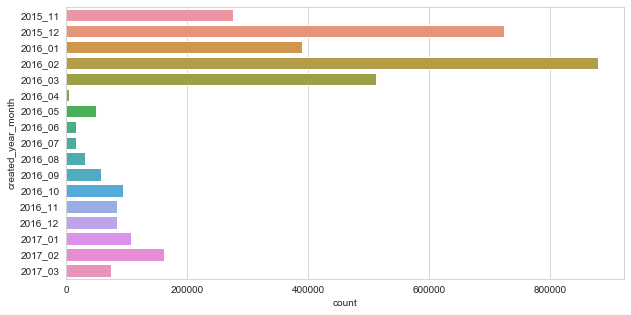

In [444]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['created_year_month'])
plt.show()

As we can see above, the volumes of car ads per month vary, especially across March and Aprill 2016. This is presumably because scrapping method had been tuned up in that time. I decided to shorten the scraping timeframe window begin from October 2016, as this should provide more coherend data and improve overall prediction accuracy.

The period is limited to October 2016 - March 2017.

In [445]:
df.groupby(['created_year_month'])['price_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
created_year_month,,,,,,,,
2015_11,274925.0,1.233104e+04,3.697931e+05,0.04,1490.2300,5366.40,13404.00,1.000148e+08
2015_12,724271.0,2.202072e+04,7.204187e+05,0.04,3951.4800,10078.98,18010.66,3.404523e+08
2016_01,389107.0,1.813875e+04,4.169198e+05,370.10,4001.5200,10408.40,18866.69,1.000074e+08
2016_02,879196.0,6.528335e+06,4.071998e+09,370.10,5657.0825,11950.00,19990.00,2.706149e+12
2016_03,511399.0,1.644282e+04,2.899182e+05,370.10,4996.8200,11499.00,19790.00,1.001332e+08
2016_04,4297.0,1.439998e+04,3.580285e+04,370.10,2849.7400,6846.78,14208.29,5.464202e+05
2016_05,48869.0,1.126372e+04,1.914449e+04,370.10,2900.1100,7134.27,14803.81,1.715063e+06
2016_06,15497.0,7.837597e+03,9.455459e+03,370.10,2775.7200,5514.43,9992.56,2.960400e+05
2016_07,15898.0,7.467093e+03,8.804289e+03,370.10,2775.7200,5181.31,9215.40,2.331606e+05


In [446]:
# checking out price_eur variance over period scraped

In [447]:
df = df[df['created_year_month'].between('2016_01','2016_03')]
df.to_csv('.\Cars_since_Oct_2016.csv')

******************************


## Data understanding and preparation

In [448]:
df = pd.read_csv('./Cars_since_Oct_2016.csv', sep=',', low_memory=False, index_col=[0])

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [449]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur,year,month,created_year_month
1258599,hyundai,i10,44373.0,2011.0,1086.0,65.710082,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.351263+00,2016-07-03 18:07:57.593938+00,5900.22,2016,1,2016_01
1258590,fiat,NaN,149000.0,2000.0,1900.0,NaN,NaN,NaN,None,man,4,None,diesel,2016-01-15 23:48:00.139562+00,2016-01-20 09:03:13.640667+00,1999.07,2016,1,2016_01
1258602,audi,a1,79850.0,2011.0,1390.0,120.691988,NaN,NaN,None,auto,2,4,gasoline,2016-01-15 23:48:18.44457+00,2016-07-03 18:08:03.813917+00,11990.45,2016,1,2016_01
1258603,hyundai,i10,25.0,2016.0,998.0,65.710082,NaN,NaN,None,auto,4,5,gasoline,2016-01-15 23:48:18.473834+00,2016-07-03 18:08:18.223965+00,9235.34,2016,1,2016_01
1258600,hyundai,i20,50785.0,2012.0,1248.0,84.484392,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.38062+00,2016-07-03 18:08:02.791752+00,8450.30,2016,1,2016_01


In [450]:
raw_len = len(df)
print(raw_len)

1779702


In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779702 entries, 1258599 to 2437959
Data columns (total 19 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
year                   int64
month                  int64
created_year_month     object
dtypes: float64(5), int64(2), object(12)
memory usage: 271.6+ MB


In [452]:
df.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission',
       'door_count', 'seat_count', 'fuel_type', 'date_created',
       'date_last_seen', 'price_eur', 'year', 'month', 'created_year_month'],
      dtype='object')

It seems that a number of variables has lots of missing values.

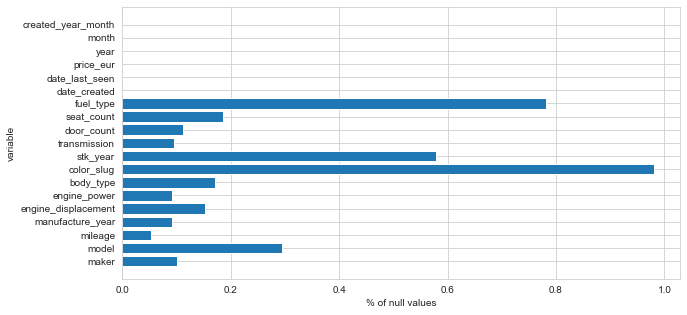

In [453]:
# checking out the % share of null values across variables
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

date_last_seen  - does not bring any useful information (as the policy was to remove all ads that had not been seen more than 60 days before scraping).

stk_year, color_slug  - variables that definitely need to be removed from the dataset, because of missing values

In [454]:
df.drop(columns=['stk_year', 'color_slug', 'date_last_seen'], inplace=True)

In [455]:
df['fuel_type'].value_counts()

gasoline    205837
diesel      183270
Name: fuel_type, dtype: int64

fuel_type might be important to predict the price, but it can not be easily imputed, since the same engine capacities can be fed with different fuel. Therefore I also decide to drop the variable.

In [456]:
df.drop(columns='fuel_type', inplace=True)

In [457]:
# dropping na values since, they will be used for missing values imputation
df.dropna(subset=['maker', 'model', 'manufacture_year'], inplace=True)

In [458]:
df['model'] = df['maker']+ ' ' + df['model']

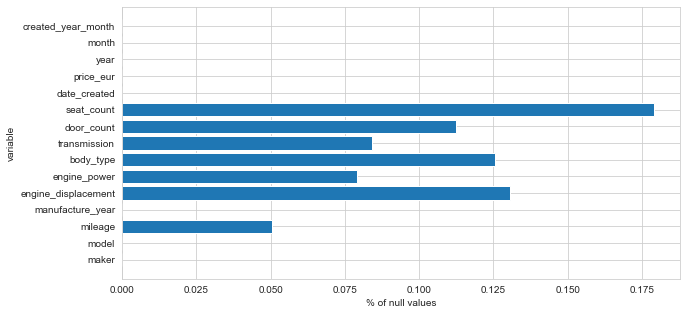

In [459]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

We next will attempt to drop outliers for door_count and seat_count.

In [460]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,year,month,created_year_month
1258599,hyundai,hyundai i10,44373.0,2011.0,1086.0,65.710082,NaN,man,4,5,2016-01-15 23:48:18.351263+00,5900.22,2016,1,2016_01
1258602,audi,audi a1,79850.0,2011.0,1390.0,120.691988,NaN,auto,2,4,2016-01-15 23:48:18.44457+00,11990.45,2016,1,2016_01
1258603,hyundai,hyundai i10,25.0,2016.0,998.0,65.710082,NaN,auto,4,5,2016-01-15 23:48:18.473834+00,9235.34,2016,1,2016_01
1258600,hyundai,hyundai i20,50785.0,2012.0,1248.0,84.484392,NaN,man,4,5,2016-01-15 23:48:18.38062+00,8450.30,2016,1,2016_01
1258601,hyundai,hyundai santa-fe,14487.0,2012.0,2199.0,194.448203,NaN,auto,4,5,2016-01-15 23:48:18.410752+00,27901.04,2016,1,2016_01


In [461]:
df[['door_count', 'seat_count']] = df[['door_count', 'seat_count']].replace('None', np.nan).apply(pd.to_numeric)

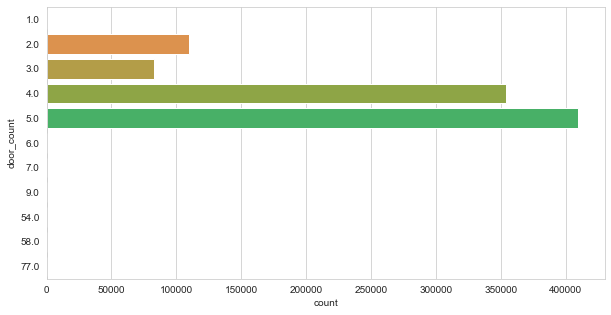

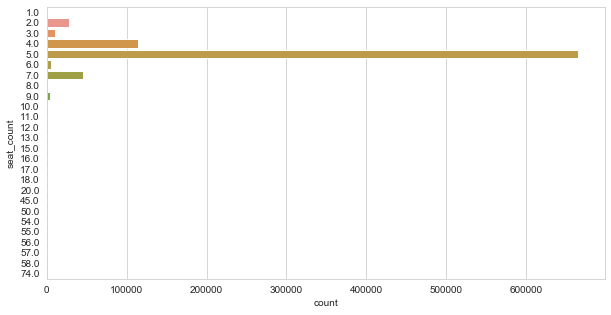

In [462]:
for i in ['door_count', 'seat_count']:
    plt.figure(figsize=(10,5))
    sns.countplot(y=df[i])
    plt.show()

Drop cars with atypical door_number

In [463]:
df = df[df['door_count'].between(2,5)]

### Imputing missing values with values across custom groups

Input millage with mean in accordance to manufacture_year of the car

In [464]:
df['mileage'] = df['mileage'].fillna(df.groupby(['manufacture_year'])['mileage'].transform('mean'))

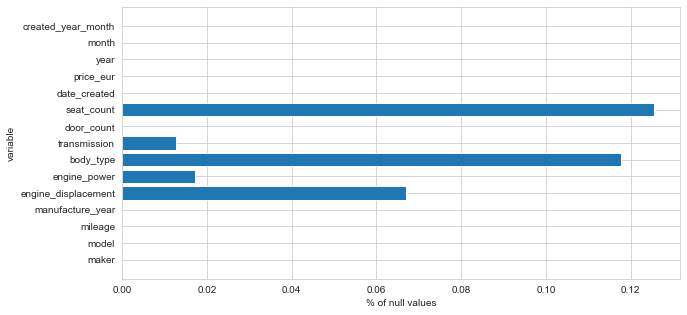

In [465]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

Impute engine_power, engine_displacement, seat_count and transmission with a mode for model and manufacture_year

In [466]:
vars = ['seat_count', 'transmission', 'engine_power', 'engine_displacement']
for i in vars:
    df[i] = df.groupby(['model'])[i].transform(lambda x: x.fillna(x.mode()))

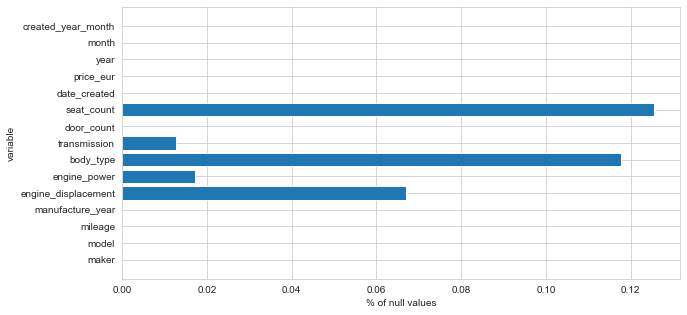

In [467]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

As no further imporovement can be reached, let's remove the records with missing values.

In [468]:
df.dropna(inplace=True)

By far the volume of the dataset is now some 40% of the initial dataset for specified period.

In [469]:
len(df), len(df)/raw_len

(721324, 0.40530605685670973)

## Filtering out the outlier values

The variables present alot of variance. Some values are out of the reasonable range. See the table below.

In [331]:
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur,year,month
count,7.213240e+05,721324.000000,721324.000000,721324.000000,721324.000000,721324.000000,7.213240e+05,721324.0,721324.000000
mean,9.118221e+04,2009.361613,1724.304159,91.500085,4.134339,4.887946,1.464024e+04,2016.0,2.329281
std,8.536632e+04,5.605343,602.334458,43.191954,0.978427,0.904570,1.178188e+06,0.0,0.505580
min,0.000000e+00,1015.000000,12.000000,10.000000,2.000000,1.000000,3.701000e+02,2016.0,1.000000
25%,2.500000e+04,2006.000000,1368.000000,66.000000,4.000000,5.000000,4.950000e+03,2016.0,2.000000
50%,8.173450e+04,2011.000000,1598.000000,81.000000,4.000000,5.000000,1.001195e+04,2016.0,2.000000
75%,1.390000e+05,2014.000000,1968.000000,105.000000,5.000000,5.000000,1.697000e+04,2016.0,3.000000
max,9.999999e+06,2016.000000,31644.000000,860.000000,5.000000,74.000000,1.000000e+09,2016.0,3.000000


In [332]:
df.describe().columns[0:7]

Index(['mileage', 'manufacture_year', 'engine_displacement', 'engine_power',
       'door_count', 'seat_count', 'price_eur'],
      dtype='object')

The will replaced with np.nan values and removed from the dataset.

In [333]:
for i in df.describe().columns[0:7]:
    df[i] = np.where(df[i].between(df[i].quantile(q=0.005), df[i].quantile(q=0.995)), df[i], np.nan)

In [334]:
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur,year,month
count,717717.000000,718101.000000,714201.000000,715950.000000,721324.000000,718160.000000,714426.000000,721324.0,721324.000000
mean,89218.445745,2009.480683,1710.077447,90.306193,4.134339,4.868978,12577.013807,2016.0,2.329281
std,71043.534153,5.169052,516.855413,38.451671,0.978427,0.833327,10618.314245,0.0,0.505580
min,0.000000,1991.000000,875.000000,37.000000,2.000000,2.000000,600.000000,2016.0,1.000000
25%,24851.000000,2006.000000,1368.000000,66.000000,4.000000,5.000000,4954.400000,2016.0,2.000000
50%,81000.000000,2011.000000,1598.000000,81.000000,4.000000,5.000000,10006.365000,2016.0,2.000000
75%,138000.000000,2014.000000,1968.000000,104.000000,5.000000,5.000000,16900.000000,2016.0,3.000000
max,333692.000000,2016.000000,4664.000000,309.000000,5.000000,8.000000,82750.000000,2016.0,3.000000


The cleaned dataset consists now of 69 7131 cars, that is 39% of the initial file.

In [335]:
df.dropna(inplace=True)

In [336]:
len(df), len(df)/raw_len

(697131, 0.39171220799886725)

Calculating the age of a car, when the ad was scraped, instead of the manufacturing_year.
Removing unnecessary columns.

In [484]:
df['car_age_years'] = (df['year']-df['manufacture_year'])
df.drop(columns=['manufacture_year', 'year', 'month'], inplace=True)

In [485]:
df['body_type'].value_counts(), df['body_type'].value_counts(normalize=True)

(other          709319
 compact          5138
 van              3610
 coupe            1158
 convertible      1119
 transporter       980
 Name: body_type, dtype: int64, other          0.983357
 compact        0.007123
 van            0.005005
 coupe          0.001605
 convertible    0.001551
 transporter    0.001359
 Name: body_type, dtype: float64)

In [486]:
df.groupby(['body_type']).describe().T

body_type                       compact    convertible         coupe  \
mileage             count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   6.995712e+04   67022.068811  8.531843e+04   
                    std    7.191741e+04   53353.243552  6.705698e+04   
                    min    0.000000e+00       0.000000  0.000000e+00   
                    25%    1.309075e+04   20300.000000  2.648650e+04   
                    50%    5.456100e+04   57683.000000  7.600000e+04   
                    75%    1.090000e+05  100000.000000  1.289000e+05   
                    max    2.200000e+06  340000.000000  3.702710e+05   
engine_displacement count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   1.319435e+03    2015.044683  2.495585e+03   
                    std    3.180164e+02     934.651122  1.115762e+03   
                    min    8.000000e+01     499.000000  5.990000e+02   
                    25%    1.108000e+03    1395.000000  1.680750e+03   
                    50%    1.248000e+03    1796.000000  1.996500e+03   
                    75%    1.497000e+03    2341.000000  3.387000e+03   
                    max    5.700000e+03    6162.000000  6.998000e+03   
engine_power        count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   8.660946e+01     171.091169  2.240827e+02   
                    std    2.990544e+01     106.449441  1.202592e+02   
                    min    1.743329e+01      18.774309  1.341022e+01   
                    25%    6.839213e+01      96.553590  1.341022e+02   
                    50%    8.046133e+01     143.489364  1.971302e+02   
                    75%    9.923563e+01     200.482802  3.003889e+02   
                    max    4.438783e+02     740.244193  6.906264e+02   
door_count          count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   3.803425e+00       2.096515  2.449050e+00   
                    std    1.122050e+00       0.337804  7.792102e-01   
                    min    2.000000e+00       2.000000  2.000000e+00   
                    25%    3.000000e+00       2.000000  2.000000e+00   
                    50%    4.000000e+00       2.000000  2.000000e+00   
                    75%    5.000000e+00       2.000000  3.000000e+00   
                    max    5.000000e+00       5.000000  5.000000e+00   
seat_count          count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   4.553912e+00       3.248436  3.706390e+00   
                    std    7.569760e-01       1.006657  9.979117e-01   
                    min    1.000000e+00       2.000000  2.000000e+00   
                    25%    4.000000e+00       2.000000  4.000000e+00   
                    50%    5.000000e+00       4.000000  4.000000e+00   
                    75%    5.000000e+00       4.000000  4.000000e+00   
                    max    9.000000e+00       6.000000  6.000000e+00   
price_eur           count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   9.214923e+03   26010.087578  3.654780e+04   
                    std    1.192399e+04   40084.937746  7.775159e+04   
                    min    5.000000e+02     700.000000  5.000000e+02   
                    25%    4.450000e+03    7900.000000  6.525000e+03   
                    50%    8.190000e+03   13500.000000  1.900000e+04   
                    75%    1.199000e+04   30570.000000  4.193750e+04   
                    max    6.875000e+05  911999.000000  1.050000e+06   
car_age_years       count  5.138000e+03    1119.000000  1.158000e+03   
                    mean   6.359868e+00       7.729223  8.962867e+00   
                    std    5.758348e+00       7.149750  7.901041e+00   
                    min    0.000000e+00       0.000000  0.000000e+00   
                    25%    1.000000e+00       3.000000  3.000000e+00   
                    50%    5.000000e+00       6.000000  7.000000e+00   
                    75%    1.000000e+01 

The category 'other' is prevailing over the body_type variable, but the general statistics show that is can be assigned to compact cars, which is the most dominant segment on the market.

In [487]:
df['body_type'][df['body_type']=='other'] = 'compact'

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [488]:
df['body_type'].value_counts(), df['body_type'].value_counts(normalize=True)

(compact        714457
 van              3610
 coupe            1158
 convertible      1119
 transporter       980
 Name: body_type, dtype: int64, compact        0.990480
 van            0.005005
 coupe          0.001605
 convertible    0.001551
 transporter    0.001359
 Name: body_type, dtype: float64)

In [489]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,car_age_years
1258396,bmw,bmw x1,38521.0,1995.0,140.807319,compact,auto,5.0,5.0,2016-01-15 23:42:05.139809+00,25500.0,2016_01,2.0
1258358,toyota,toyota aygo,2.0,998.0,67.051104,compact,man,3.0,4.0,2016-01-15 23:42:00.884465+00,10490.0,2016_01,1.0
1258357,toyota,toyota aygo,2.0,998.0,67.051104,compact,man,5.0,4.0,2016-01-15 23:42:00.811707+00,10990.0,2016_01,1.0
1258391,bmw,bmw x3,21912.0,1995.0,187.743092,compact,auto,5.0,5.0,2016-01-15 23:42:04.651815+00,43999.0,2016_01,2.0
1258381,toyota,toyota aygo,2.0,998.0,67.051104,compact,man,3.0,4.0,2016-01-15 23:42:03.49436+00,10490.0,2016_01,1.0


*************************

In [490]:
df.to_csv('.\Cars_cleaned_all_600k.csv')

In [491]:
df = df.sample(n=50000, random_state=random_seed)
df.to_csv('.\Cars_cleaned_50k.csv')

In [492]:
len(df)

50000

## Car Clustering

In order to better predict car prices I will attempt to cluster cars into some more homogenic groups. The clusters will be considered in furher price predictions.
Please note that due to manufacturer downsizing the same engine_displacement can result in completely different engine_power in accordance to age and make of a car.

In [397]:
df['engine_power'][df['engine_displacement'].between(1490,1495)].describe()

count    63.000000
mean     68.523810
std       9.469573
min      50.000000
25%      60.000000
50%      70.000000
75%      75.000000
max      84.000000
Name: engine_power, dtype: float64

In [398]:
data_for_clustering = df[['engine_power', 'door_count', 'seat_count']]

In [399]:
data_for_clustering.head()

,engine_power,door_count,seat_count
1844903,103.0,4.0,7.0
1661143,110.0,4.0,5.0
2574412,55.0,5.0,5.0
2230070,130.0,2.0,4.0
1623819,55.0,3.0,5.0


In [400]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

data_clustered = StandardScaler().fit_transform(data_for_clustering)

clusters = range(2, 10)
silhouette = []
inertia  = []
for k in clusters:
    
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=random_seed)
    
    model.fit(data_clustered)
    
    silhouette.append(silhouette_score(data_clustered, model.predict(data_clustered)))
    inertia.append(model.inertia_)

Plotting Silhouette and Inertia to set up optimal number of clusters

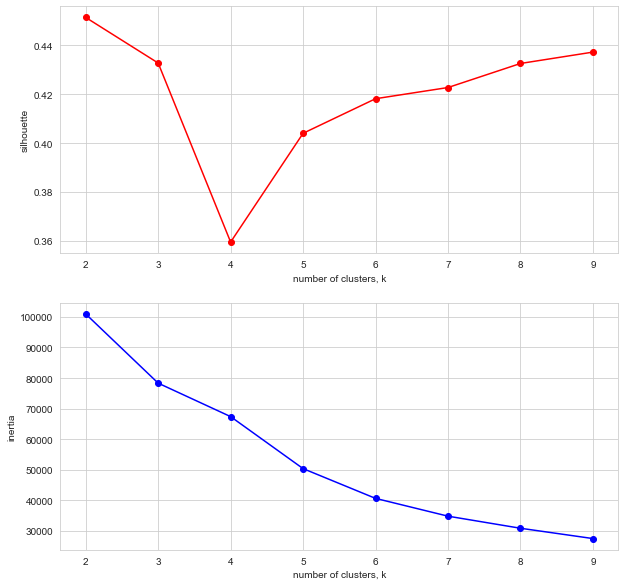

In [401]:
# Plot clusters vs silhouette
plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(clusters, silhouette, 'r-o', )
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')

plt.subplot(2, 1, 2)
# Plot clusters vs silhouette
plt.plot(clusters, inertia, 'b-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')

plt.show()

In [402]:
cluster_model = MiniBatchKMeans(n_clusters=9)
cluster_model.fit(data_clustered)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=9, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [416]:
df['cluster']=cluster_model.predict(data_clustered)

In [417]:
df['cluster'].value_counts()

1    14563
0    10754
5     8907
7     3790
3     3667
4     2948
6     2393
2     1709
8     1269
Name: cluster, dtype: int64

In [418]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,car_age,cluster
1844903,volkswagen,volkswagen touran,283800.00000,1968.0,103.0,compact,man,4.0,7.0,2016-02-19 18:37:11.530665+00,3991.49,2016_02,12.0,4
1661143,volkswagen,volkswagen golf,11346.00000,1395.0,110.0,compact,man,4.0,5.0,2016-02-16 06:41:58.129186+00,18909.88,2016_02,2.0,0
2574412,skoda,skoda fabia,162515.00463,1390.0,55.0,compact,man,5.0,5.0,2016-03-07 18:02:47.258691+00,2586.97,2016_03,13.0,1
2230070,peugeot,peugeot 307,132000.00000,1997.0,130.0,compact,man,2.0,4.0,2016-02-28 21:34:49.714787+00,4897.96,2016_02,12.0,8
1623819,peugeot,peugeot 206,115000.00000,1360.0,55.0,compact,man,3.0,5.0,2016-02-15 11:31:14.566069+00,1499.00,2016_02,17.0,7


In [438]:
grouper = df.groupby(by='cluster')['engine_power', 'door_count', 'seat_count'].mean()

Check out how the cluster differ

In [436]:
df['engine_power'] = 1.3410220888*df['engine_power']

In [439]:
print(grouper)

         engine_power  door_count  seat_count
cluster                                      
0          153.078906    4.495537    4.973963
1           95.141203    5.000000    4.928243
2           97.594079    3.255705    2.289643
3           89.412931    2.496319    3.989637
4          137.879633    4.587517    7.014925
5           97.847789    4.000000    4.955653
6          250.423687    4.394484    4.952779
7           86.835249    2.593668    5.001583
8          225.760910    2.200158    3.918046


In [476]:
df[df['model']=='ford mondeo']

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,year,month,created_year_month
1283080,ford,ford mondeo,200905.0,2007.0,1999.0,143.489364,compact,man,5.0,5.0,2016-01-17 07:05:57.247628+00,5999.0,2016,1,2016_01
1279465,ford,ford mondeo,25597.0,2015.0,1997.0,147.512430,other,man,4.0,5.0,2016-01-17 03:38:04.490114+00,24990.0,2016,1,2016_01
1268435,ford,ford mondeo,10.0,2015.0,1498.0,158.240606,compact,man,5.0,5.0,2016-01-16 11:13:57.6394+00,30545.0,2016,1,2016_01
1268399,ford,ford mondeo,139899.0,2009.0,2295.0,158.240606,compact,auto,5.0,5.0,2016-01-16 11:13:55.157784+00,10950.0,2016,1,2016_01
1196896,ford,ford mondeo,327902.0,2004.0,1998.0,113.986878,compact,man,5.0,5.0,2016-01-12 05:55:50.321209+00,1695.0,2016,1,2016_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436245,ford,ford mondeo,22539.0,2015.0,1997.0,147.512430,other,man,5.0,5.0,2016-03-04 07:06:05.648259+00,21500.0,2016,3,2016_03
2436022,ford,ford mondeo,274104.0,2003.0,1998.0,128.738121,other,man,5.0,5.0,2016-03-04 07:05:34.748244+00,1400.0,2016,3,2016_03
2438907,ford,ford mondeo,16000.0,2015.0,1997.0,147.512430,other,man,4.0,5.0,2016-03-04 07:11:23.855407+00,27846.0,2016,3,2016_03
2438945,ford,ford mondeo,142000.0,1998.0,1796.0,113.986878,other,man,4.0,5.0,2016-03-04 07:11:27.108753+00,1250.0,2016,3,2016_03


In [477]:
df.to_csv('.\Cars_cleaned.csv')

In [478]:
df = pd.read_csv('.\cars_cleaned.csv'', sep=',', index_col=[0], )

SyntaxError: EOL while scanning string literal (<ipython-input-478-8918955077d7>, line 1)

# Setting up the train_test_split and pipeline

### Define target variable and split dataset

In [529]:
df.columns

Index(['maker', 'model', 'mileage', 'engine_displacement', 'engine_power',
       'body_type', 'transmission', 'door_count', 'seat_count', 'date_created',
       'price_eur', 'created_year_month', 'car_age_years'],
      dtype='object')

In [532]:
y = df['price_eur']
X = df.drop(['maker', 'model', 'transmission', 'body_type', 'price_eur', 'date_created', 'created_year_month'], axis=1)

In [533]:
X.columns

Index(['mileage', 'engine_displacement', 'engine_power', 'door_count',
       'seat_count', 'car_age_years'],
      dtype='object')

In [534]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [535]:
X.head()

,mileage,engine_displacement,engine_power,door_count,seat_count,car_age_years
2724200,69000.0,998.0,67.051104,5.0,4.0,9.0
2158162,85350.0,1397.0,93.871546,3.0,4.0,8.0
2509580,273843.0,1598.0,99.235635,5.0,7.0,15.0
1770281,59127.0,1560.0,107.281767,5.0,5.0,7.0
2008301,75386.0,1560.0,103.258701,5.0,5.0,3.0


In [536]:
df.describe().columns

Index(['mileage', 'engine_displacement', 'engine_power', 'door_count',
       'seat_count', 'price_eur', 'car_age_years'],
      dtype='object')

### Specify pipeline

In [537]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Create the preprocessing pipelines for both numeric and categorical data.
numeric_features = df.describe().columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['maker', 'model', 'body_type', 'transmission']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [ ]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [580]:
# switch off future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [581]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=5, random_state=random_seed)

In [499]:
from sklearn.model_selection import GridSearchCV

###  Linear regression

In [554]:
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [577]:
#LR
lm_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression(n_jobs=1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)
lm_1.fit(X, y)

{'polynomialfeatures__degree': 2}

In [585]:
from sklearn import metrics
print(lm_1.best_params_, 'r2:', metrics.r2_score(y_test, lm_1.predict(X_test)))

{'polynomialfeatures__degree': 2} r2: 0.5824527654062672


In [579]:
#Ridge
lm_2_rr = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge(random_state=random_seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
                    cv=kfold,
                    refit=True)
lm_2_rr.fit(X, y)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.90298e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.10779e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.85066e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.01667e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.93463e-17): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.52291e

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.21982e-41): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.97309e-41): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.95793e-40): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.96594e-39): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.87716e-40): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.21982e

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72615e-51): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.06159e-50): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69288e-51): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.812e-51): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70249e-51): result may not be accurate.
  overwrite_a=True).T
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61532e-5

{'polynomialfeatures__degree': 2, 'ridge__alpha': 1000}

In [591]:
from sklearn import metrics
print(lm_2_rr.best_params_, 'r2:', metrics.r2_score(y_test, lm_2_rr.predict(X_test)))

{'polynomialfeatures__degree': 2, 'ridge__alpha': 1000} r2: 0.5820565581813383


In [594]:
#Lasso
lm_3_lr = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.Lasso(random_state=random_seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
                    cv=kfold,
                    refit=True)
lm_3_lr.fit(X, y)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847212536131.0703, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2683388417450.4185, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1927270278610.7722, tolerance: 975857807.8994541
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242430516321.3525, tolerance: 10748959

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242433721507.76, tolerance: 1074895914.1012208
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2590769485381.3506, tolerance: 1130553936.6877866
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2209239903257.283, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025000384323.036, tolerance: 1199022251.

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025356477924.5598, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1593386300324.7832, tolerance: 975857807.8994541
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1592832523420.1516, tolerance: 1074895914.1012208
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2095842448636.2952, tolerance: 11305539

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2105373846392.625, tolerance: 1130553936.6877866
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1774745272800.328, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1620924118881.048, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452276649910.783, tolerance: 975857807.8

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                                              selection='cyclic', tol=0.0001,
                                              warm_start

In [595]:
print(lm_3_lr.best_params_, 'r2:', metrics.r2_score(y_test, lm_3_lr.predict(X_test)))

{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 3} r2: 0.7284181187949481


In [596]:
#ElasticNet
lm_4_enr = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, random_state=random_seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
                    cv=kfold,
                    refit=True)
lm_4_enr.fit(X, y)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847235812055.2886, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2683410967273.6865, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1927287494051.4612, tolerance: 975857807.8994541
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242453653776.2495, tolerance: 10748959

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2244389110005.0728, tolerance: 1074895914.1012208
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2592061567536.5786, tolerance: 1130553936.6877866
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2210394468105.7207, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2026025544029.525, tolerance: 11990222

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2030046949717.5325, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1597310715402.8743, tolerance: 975857807.8994541
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1597003914437.714, tolerance: 1074895914.1012208
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2102033761041.5168, tolerance: 113055393

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2116310961937.8398, tolerance: 1130553936.6877866
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1773663789400.3398, tolerance: 1223808030.5116122
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1618490631815.367, tolerance: 1199022251.6402428
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450668800216.8862, tolerance: 97585780

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('elasticnet',
                                        ElasticNet(alpha=1, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
            

In [597]:
print(lm_4_enr.best_params_, 'r2:', metrics.r2_score(y_test, lm_4_enr.predict(X_test)))

{'elasticnet__alpha': 0.0001, 'polynomialfeatures__degree': 3} r2: 0.7284174245065462


### Support Vector Regression

In [598]:
#SVR
from sklearn.svm import SVR

from sklearn.svm import SVR
svr_5 = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=kfold,
                   param_grid={"C":  [0.1 ,1, 2, 3, 4, 10,40,100],
                               "gamma": [0.001, 0.01, 0.1, 1, 10]})

svr_5.fit(X, y)

KeyboardInterrupt: 

In [ ]:
print(svr_5.best_params_, 'r2:', metrics.r2_score(y_test, svr_5.predict(X_test)))

###  Random forest regression

In [599]:
# mod
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth':  [50, 100, 200, 200],
    'max_features': ['log2','sqrt','auto'],
    'max_leaf_nodes':  [100, 200]
}

rf = RandomForestRegressor(n_jobs=-1, max_features= 'sqrt', n_estimators=50, 
                           oob_score = True, random_state=random_seed)

rfr_6 = GridSearchCV(estimator=rfc,
                      param_grid=param_grid,
                      cv=kfold)

rfr_6.fit(X, y)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=None,
                                             verbose=

In [601]:
print(rfr_6.best_params_, 'r2:', metrics.r2_score(y_test, rfr_6.predict(X_test)), rfr_6.best_estimator_)

{'max_depth': 200, 'max_features': 'log2', 'max_leaf_nodes': 200, 'n_estimators': 100} r2: 0.9312829400511826 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=200, max_features='log2', max_leaf_nodes=200,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)


By far Random forest algorithm brought out 93% R2 score, which is far better than of the bul of  Linear Regression models. Can we go better?

## Gradient Boosting regressor

In [ ]:
gbrt=GradientBoostingRegressor(n_estimators=100) gbrt.fit(X_train, y_train) y_pred=gbrt.predict(X_test) - See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.iCSRgCmQ.dpuf

In [602]:
from sklearn import metrics

models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('SVR', grid_5.best_estimator_))
models.append(('Random Forrest', grid_6.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_testb model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

SyntaxError: invalid syntax (<ipython-input-602-bf0047c44390>, line 26)

In [ ]:
#https://data.world/data-society/used-cars-data

In [ ]:
# Regression Tutorial with the Keras Deep Learning Library in Python
#https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
NNmodel = Sequential()
NNmodel.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu')) # ustalić liczbę zmiennych wejściowych
NNmodel.add(Dense(1, kernel_initializer='normal'))
NNmodel.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

def create_model():
    model = Sequential()
    model.add(Dense(10,
                input_dim=X.shape[1],
                activation="relu"))
    model.add(Dense(10,
                activation="relu"))
    model.add(Dense(1))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=[det_coeff])
    return model

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
#from sklearn.ensemble import GradientBoostingRegressor
#reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)